# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

## Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline



/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

In [5]:
df.shape[0]

294478

**d.** The proportion of users converted.

In [6]:
df.query('converted == 1').shape[0]/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df.query('group == "treatment" & landing_page != "new_page"').shape[0]

1965

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |



In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df_control = df.query('group == "control" & landing_page == "old_page"')
df_treatment = df.query('group == "treatment" & landing_page == "new_page"')
df2=df_control.append(df_treatment)
df2.shape[0]


290585

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2.drop_duplicates(subset = 'user_id', inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2.shape[0]==df2.user_id.nunique()


True


**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [15]:
df2.query('converted == 1').shape[0]/df2.shape[0]

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('converted == 1 & group =="control" ').shape[0]/df2.query('group =="control"').shape[0]

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('converted == 1 & group =="treatment" ').shape[0]/df2.query('group =="treatment"').shape[0]

0.11880806551510564

Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2.query('converted == 1 & group =="treatment" ').shape[0]/df2.query('group =="treatment"').shape[0] - df2.query('converted == 1 & group =="control" ').shape[0]/df2.query('group =="control"').shape[0]
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

In [20]:
df2.query('converted == 1').shape[0]/df2.shape[0]

0.11959708724499628

Conclusion I

>**Since The probability of conversion given control group is more, then the treatment group users doesnt lead to more conversion.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider you need to make the decision just based on all the data provided.  


>**The null and alternative are.**

>**$H_0$** :  $p_{new}$ - $p_{old} $ <= 0

>**$H_1$** :  $p_{new}$ - $p_{old}$ > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>



**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2.query('converted == 1').shape[0]/df2.shape[0]
p_new 

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2.query('converted == 1').shape[0]/df2.shape[0]
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [23]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('group != "treatment"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2,size = n_new , p =[1-p_new, p_new] )

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2,size = n_old , p =[1-p_old, p_old] )

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
old_page_converted.mean() - new_page_converted.mean() 

-0.00033539141814811768


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.choice(2,size = n_old , p =[1-p_new, p_new] )
    new_page_converted = np.random.choice(2,size = n_new , p =[1-p_new, p_new] )
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
# Convert to numpy array
p_diffs = np.array(p_diffs)


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


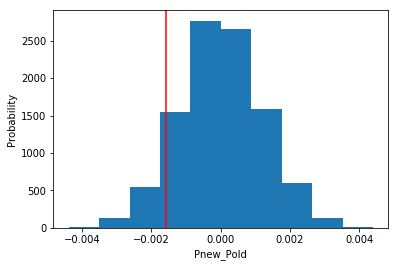

In [29]:
# Plot sampling distribution
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color = 'red');
plt.xlabel('Pnew_Pold');
plt.ylabel('Probability');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
(p_diffs>obs_diff).mean()

0.90710000000000002



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('converted == 1 & group =="control" ').shape[0]

# number of conversions with the new_page
convert_new =df2.query('converted == 1 & group =="treatment" ').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').shape[0]

# number of individuals who received new_page
n_new =df2.query('group == "treatment"').shape[0]

In [32]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
#proportions_ztest(count_array, nobs_array, alternative='larger')
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>*The value is not larger than $Z_{\alpha} = 1.645$ which means the conversion rates of the old page is more than the new page. The p-value matches that calculated in j and k which failed to reject the null as well**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic regression is the best option since we are interested a binary output (converted or not converted) .**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [34]:
df2['intercept'] = 1
df2[['drop','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop',axis = 1,inplace = True)


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
log_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-08 09:11 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



>**The p-value = 0.189 it's different from that found in part 2 because the logistic regression test is a 2 sided test where the alternative hypthesis H1: β_abpage <> 0.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Its good to consider other factors and perform multiple regresion because this helps determine which variables are truley independant and are actually statistically significant. Disadvantages might be reducing model accuracy if the correlation of some variables are not strong.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
 Provide the statistical output as well as a written response to answer this question.

In [37]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')


In [38]:
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Join with the df2 dataframe
df_merged = df2.merge(df3 , on = 'user_id')

In [40]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [41]:
#pd.get_dummies(df_merged['country'])

In [42]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.drop('US',axis = 1,inplace = True)
df_merged.tail()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
290579,677163,2017-01-03 19:41:51.902148,treatment,new_page,0,1,1,US,0,0
290580,925675,2017-01-07 20:38:26.346410,treatment,new_page,0,1,1,US,0,0
290581,643562,2017-01-02 19:20:05.460595,treatment,new_page,0,1,1,CA,1,0
290582,822004,2017-01-04 03:36:46.071379,treatment,new_page,0,1,1,CA,1,0
290583,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,UK,0,1


In [43]:
log_mod2 = sm.Logit(df_merged.converted, df_merged[['intercept', 'CA', 'UK']])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-08 09:11 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

>**The p-values for both country variables is significanlty larger than the Type 1 error rate so we fail to reject the null hypothesis(p <= 0.025 for two sided tests). Hence, we cannot confidenlty predict conversion based on country.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [44]:
# Fit your model, and summarize the results
df_merged['interactionCA'] = df_merged.CA * df_merged.ab_page
df_merged['interactionUK'] = df_merged.UK * df_merged.ab_page



In [45]:
df_merged.tail()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,interactionCA,interactionUK
290579,677163,2017-01-03 19:41:51.902148,treatment,new_page,0,1,1,US,0,0,0,0
290580,925675,2017-01-07 20:38:26.346410,treatment,new_page,0,1,1,US,0,0,0,0
290581,643562,2017-01-02 19:20:05.460595,treatment,new_page,0,1,1,CA,1,0,1,0
290582,822004,2017-01-04 03:36:46.071379,treatment,new_page,0,1,1,CA,1,0,1,0
290583,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,UK,0,1,0,1


In [46]:
log_mod3 = sm.Logit(df_merged.converted, df_merged[['intercept','ab_page','CA', 'UK','interactionCA','interactionUK']])
results = log_mod3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-08 09:11 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
ab_page          -0.0206   0.0137   -1.5052 0.1323 -0.0473  0.0062
CA               -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
UK               -0.0057   0.0188   -0.3057 0.7598 -0.0426  0.0311
interactionCA    -0.0469   0.0538   -0.8718 0.3833 -0.1523  0.0585
interactionUK     0.0314   0.0266    1.1807 0.2377 -0.0207  0.0835
==================================================================

"""

>**After Considering interaction, The p-values for both country variables is significanlty larger than the Type 1 error rate (p <= 0.025 for two sided tests) so we fail to reject the null hypothesis. Hence, in practice we cannot confidenlty predict conversion based on interaction between page type and country.**

>**Final conclusion: All tests lead to the final conclusion where we fail to reject the null hypothesis, The first two methods were faster but regression gave us more flexibility to explore multiple variables, interactions and gain more insights.**